In [15]:
import pandas as pd
import numpy as np
import sklearn.model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from mealpy.swarm_based import GWO
from mealpy import Problem
# import optuna

In [7]:
df = pd.read_excel(r"E:\BaiduSyncdisk\A-研究生学习\6-22任务\数据集及文献\1数据集.xlsx")
print(df.columns.tolist())

['NO.', 'Name ', 'Sample\n成分Sr1-xLaxFe12-yCoyO19', 'Strontium Carbonate（w.t.%）\n碳酸锶SrCO3质量分数', 'Iron oxide（w.t.%）\nFe2O3质量分数', 'Lanthanum Oxide（w.t.%）\nLa2O3质量分数', 'Cobalt Oxide（w.t.%）\nCo2O3质量分数', 'Temperature（℃）\n温度', 'Saturation Magnetization/Ms-5 T (emu/g) Experiment\n饱和磁化强度', 'Coercivity/Hcj (Oe) Experiment\n矫顽力', 'Unnamed: 10']


In [8]:
features = [
    'Strontium Carbonate（w.t.%）\n碳酸锶SrCO3质量分数', 'Iron oxide（w.t.%）\nFe2O3质量分数', 'Lanthanum Oxide（w.t.%）\nLa2O3质量分数', 'Cobalt Oxide（w.t.%）\nCo2O3质量分数'
]
target = 'Saturation Magnetization/Ms-5 T (emu/g) Experiment\n饱和磁化强度'
 # 或者 "HcJ"

In [9]:
X = df[features].values
y = df[target].values

## 数据预处理
归一化方法
$$ X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} $$

In [10]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

## 划分训练测试集

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)

## 自定义 GWO 优化器

In [19]:
def gwo_optimize(fitness_func, dim, n_agents=10, n_iter=100, bounds=(1e-3, 1000)):
    lb, ub = bounds
    alpha_pos, alpha_score = np.zeros(dim), float('inf')
    beta_pos, beta_score = np.zeros(dim), float('inf')
    delta_pos, delta_score = np.zeros(dim), float('inf')

    positions = np.random.uniform(lb, ub, (n_agents, dim))

    for iter in range(n_iter):
        for i in range(n_agents):
            score = fitness_func(positions[i])
            if score < alpha_score:
                alpha_score, alpha_pos = score, positions[i].copy()
            elif score < beta_score:
                beta_score, beta_pos = score, positions[i].copy()
            elif score < delta_score:
                delta_score, delta_pos = score, positions[i].copy()

        a = 2 - iter * (2 / n_iter)
        for i in range(n_agents):
            for j in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A1, C1 = 2*a*r1 - a, 2*r2
                D_alpha = abs(C1*alpha_pos[j] - positions[i, j])
                X1 = alpha_pos[j] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2*a*r1 - a, 2*r2
                D_beta = abs(C2*beta_pos[j] - positions[i, j])
                X2 = beta_pos[j] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2*a*r1 - a, 2*r2
                D_delta = abs(C3*delta_pos[j] - positions[i, j])
                X3 = delta_pos[j] - A3 * D_delta

                positions[i, j] = np.clip((X1 + X2 + X3) / 3, lb, ub)

    return alpha_pos, alpha_score

## 适应度函数（用 MAE 作为目标）

In [20]:
def fitness(params):
    gamma, C = params
    svr = SVR(kernel='rbf', gamma=gamma, C=C)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_train)
    return mean_absolute_error(y_train, y_pred)

## 执行 GWO 超参数优化

In [21]:
best_params, best_score = gwo_optimize(fitness_func=fitness, dim=2, n_agents=20, n_iter=30)
best_gamma, best_C = best_params
print(f"最佳参数：gamma={best_gamma:.5f}, C={best_C:.2f}")

最佳参数：gamma=28.57120, C=576.76


##  用最佳参数训练 SVR 并评估

In [24]:
model = SVR(kernel='rbf', gamma=best_gamma, C=best_C)
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")

MAE: 2.1074
RMSE: 2.5873
R²: 0.7190


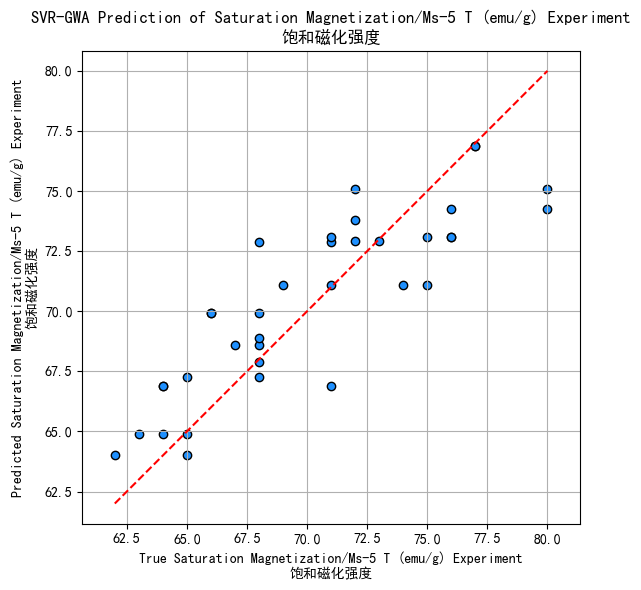

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   

# 实际 vs 预测
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, color='dodgerblue', edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True " + target)
plt.ylabel("Predicted " + target)
plt.title(f"SVR-GWA Prediction of {target}")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

使用交叉验证的适应度函数

In [40]:
def fitness2(solution):
    gamma, C = solution
    gamma = max(gamma, 1e-4)  # 防止取值为0
    C = max(C, 1e-2)
    svr = SVR(kernel='rbf', gamma=gamma, C=C)
    scores = sklearn.model_selection.cross_val_score(svr, X_train, y_train, cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    return mae

In [41]:
from mealpy.utils.space import FloatVar 
bounds = [
    FloatVar(lb=1e-4, ub=10, name="gamma"),  # gamma 参数，连续范围 [1e-4, 10]
    FloatVar(lb=1e-2, ub=1000, name="C"),    # C 参数，连续范围 [1e-2, 1000]
]
problem=Problem(
    bounds=bounds,
    obj_func=fitness2,
    minmax="min",
    name="SVR Hyperparameter Optimization"
)

# 初始化 GWO 优化器（也可以换 PSO、GA）
model = GWO.OriginalGWO(epoch=100, pop_size=50)
best_agent = model.solve(problem)  # 返回 Agent 对象

# 从 Agent 对象中提取最优解和适应度值
best_position = best_agent.solution  # 最优参数
best_fitness = best_agent.target.fitness  # 最优适应度值

print(f"最优参数: gamma={best_position[0]:.6f}, C={best_position[1]:.6f}")
print(f"最优 MAE: {best_fitness:.6f}")


2025/06/30 04:15:19 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: OriginalGWO(epoch=100, pop_size=50)
2025/06/30 04:15:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: SVR Hyperparameter Optimization, Epoch: 1, Current best: 0.08655453583233481, Global best: 0.08655453583233481, Runtime: 0.40393 seconds
2025/06/30 04:15:20 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: SVR Hyperparameter Optimization, Epoch: 2, Current best: 0.08650974935951568, Global best: 0.08650974935951568, Runtime: 0.34279 seconds
2025/06/30 04:15:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: SVR Hyperparameter Optimization, Epoch: 3, Current best: 0.08650704598675796, Global best: 0.08650704598675796, Runtime: 0.35981 seconds
2025/06/30 04:15:21 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: SVR Hyperparameter Optimization, Epoch: 4, Current best: 0.08648738389071674, Global best: 0.08648738389071674, Runtime: 0.34019 seconds
2025/06/30 04:15:21 PM, INFO, mealpy.s

最优参数: gamma=8.361965, C=0.462310
最优 MAE: 0.085847


In [42]:
model = SVR(kernel='rbf', gamma=best_position[0], C=best_position[1])
model.fit(X_train, y_train)
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")

MAE: 1.9715
RMSE: 2.3892
R²: 0.7604


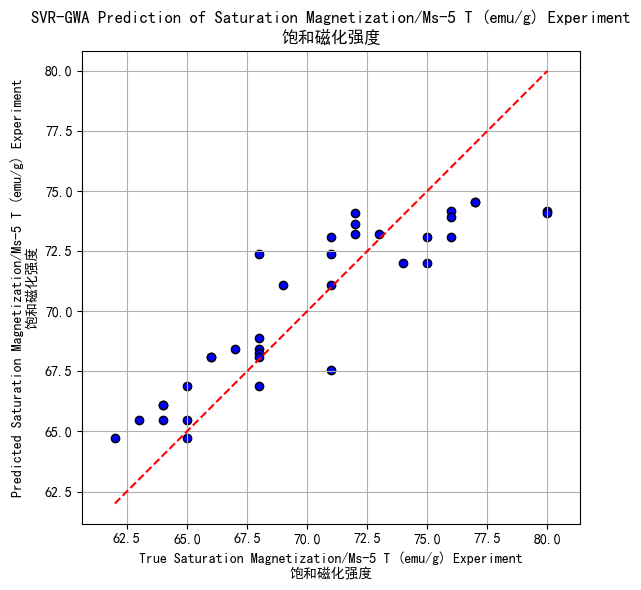

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False   

# 实际 vs 预测
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, color='blue', edgecolors='k')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("True " + target)
plt.ylabel("Predicted " + target)
plt.title(f"SVR-GWA Prediction of {target}")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

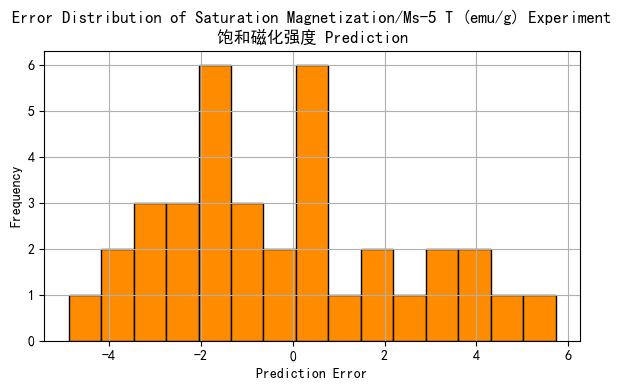

In [12]:
errors = y_true - y_pred
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=15, color='darkorange', edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title(f"Error Distribution of {target} Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

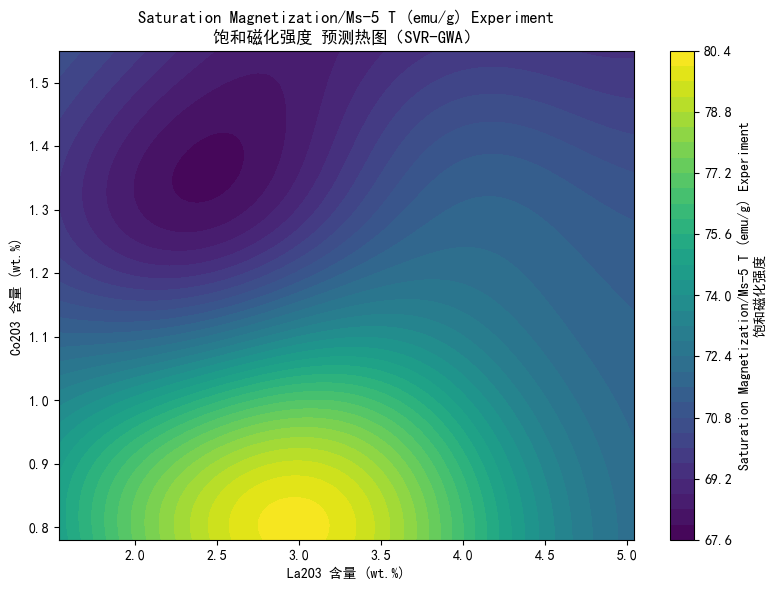

In [30]:
# 正确的列名（与你 features 中一致）
la_col = 'Lanthanum Oxide（w.t.%）\nLa2O3质量分数'
co_col = 'Cobalt Oxide（w.t.%）\nCo2O3质量分数'
sr_col = 'Strontium Carbonate（w.t.%）\n碳酸锶SrCO3质量分数'
fe_col = 'Iron oxide（w.t.%）\nFe2O3质量分数'

# 构建网格数据
la_range = np.linspace(df[la_col].min(), df[la_col].max(), 100)
co_range = np.linspace(df[co_col].min(), df[co_col].max(), 100)
la_grid, co_grid = np.meshgrid(la_range, co_range)

# 其余成分使用平均值（Sr 和 Fe）
sr_mean = df[sr_col].mean()
fe_mean = df[fe_col].mean()

# 组合成模型输入特征
grid_points = np.c_[
    np.full(la_grid.size, sr_mean),
    np.full(la_grid.size, fe_mean),
    la_grid.ravel(),
    co_grid.ravel()
]

# 归一化处理
grid_scaled = scaler_X.transform(grid_points)

# 预测 Ms 或 HcJ
grid_pred_scaled = model.predict(grid_scaled)
grid_pred = scaler_y.inverse_transform(grid_pred_scaled.reshape(-1, 1)).reshape(la_grid.shape)

# 绘图
plt.figure(figsize=(8, 6))
cp = plt.contourf(la_grid, co_grid, grid_pred, levels=30, cmap='viridis')
plt.xlabel("La2O3 含量 (wt.%)")
plt.ylabel("Co2O3 含量 (wt.%)")
plt.title(f"{target} 预测热图（SVR-GWA）")
plt.colorbar(cp, label=target)
plt.tight_layout()
plt.show()